<a href="https://colab.research.google.com/github/Papa-Panda/Paper_reading/blob/main/MAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

100%|██████████| 170498071/170498071 [00:05<00:00, 30675519.22it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
# Step 2: Define a simple autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # 16x16 -> 8x8
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), # 8x8 -> 4x4
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 4x4 -> 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),     # 16x16 -> 32x32
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
# Step 3: Define Masking Function (Random patches)
def mask_image(x, mask_ratio=0.75):
    N, C, H, W = x.shape
    num_patches = int(mask_ratio * H * W)
    mask = torch.ones((N, 1, H, W), device=x.device)

    for i in range(N):
        indices = np.random.choice(H * W, num_patches, replace=False)
        mask.view(N, -1)[i, indices] = 0

    x_masked = x * mask
    return x_masked, mask

# Step 4: Define Loss Function (MAE for masked patches)
def masked_loss(reconstructed, original, mask):
    loss = (torch.abs(reconstructed - original) * mask).mean()
    return loss


In [ ]:
# Step 5: Initialize Model, Optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Autoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

# Step 6: Training Loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        inputs, _ = data
        inputs = inputs.to(device)

        # Mask image
        masked_inputs, mask = mask_image(inputs, mask_ratio=0.75)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(masked_inputs)
        loss = masked_loss(outputs, inputs, mask)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
          print(f"Epoch [{epoch+1}/{num_epochs}], sample {i}, Loss:{running_loss/len(trainloader)}")
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader)}")

print("Finished Training")

Epoch [1/10], sample 99, Loss:0.007598922042476247
Epoch [1/10], sample 199, Loss:0.012575233669575218
Epoch [1/10], sample 299, Loss:0.01686519249806852
Epoch [1/10], sample 399, Loss:0.02080404895888951
Epoch [1/10], sample 499, Loss:0.02442239278979847
Epoch [1/10], sample 599, Loss:0.02779328705423781
Epoch [1/10], sample 699, Loss:0.030929499408206367
Epoch [1/10], Loss: 0.03338114223669252
Epoch [2/10], sample 99, Loss:0.002878128674805469
Epoch [2/10], sample 199, Loss:0.005685703221546567
Epoch [2/10], sample 299, Loss:0.008396768744777688
Epoch [2/10], sample 399, Loss:0.01101355829878765
Epoch [2/10], sample 499, Loss:0.01354123528122597
Epoch [2/10], sample 599, Loss:0.01601275556561206
Epoch [2/10], sample 699, Loss:0.018402244402643514
Epoch [2/10], Loss: 0.020328352173023364
Epoch [3/10], sample 99, Loss:0.0022658261749178856
Epoch [3/10], sample 199, Loss:0.004522526498569552
Epoch [3/10], sample 299, Loss:0.006688167624499487
Epoch [3/10], sample 399, Loss:0.00884198964

Files already downloaded and verified


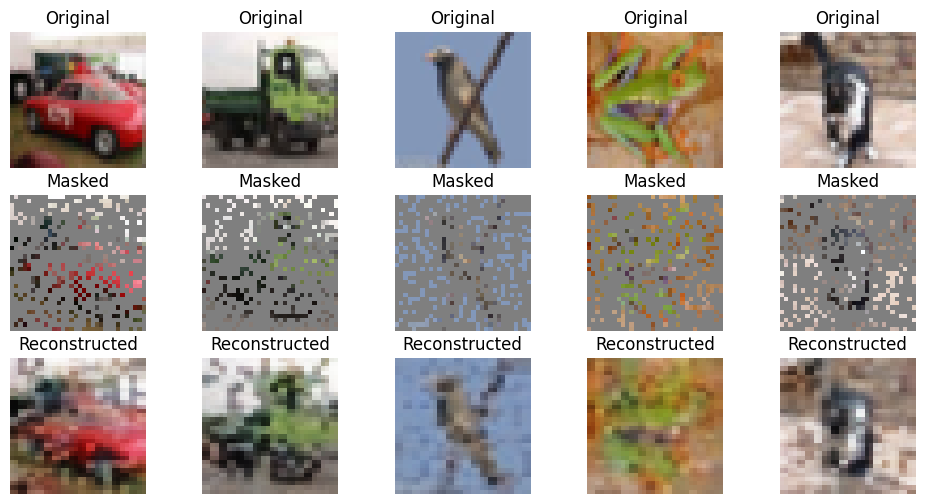

In [10]:
import matplotlib.pyplot as plt

# Function to display the original, masked, and reconstructed images
def show_images(original, masked, reconstructed, num_images=5):
    original = original.cpu().detach().numpy().transpose(0, 2, 3, 1)
    masked = masked.cpu().detach().numpy().transpose(0, 2, 3, 1)
    reconstructed = reconstructed.cpu().detach().numpy().transpose(0, 2, 3, 1)

    fig, axs = plt.subplots(3, num_images, figsize=(12, 6))
    for i in range(num_images):
        axs[0, i].imshow((original[i] * 0.5 + 0.5))  # De-normalize for display
        axs[0, i].set_title('Original')
        axs[0, i].axis('off')

        axs[1, i].imshow((masked[i] * 0.5 + 0.5))    # De-normalize for display
        axs[1, i].set_title('Masked')
        axs[1, i].axis('off')

        axs[2, i].imshow((reconstructed[i] * 0.5 + 0.5))  # De-normalize for display
        axs[2, i].set_title('Reconstructed')
        axs[2, i].axis('off')

    plt.show()

# Get some test data from CIFAR-10
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=8, shuffle=True)

# Load one batch of test images
dataiter = iter(testloader)
images, labels = next(dataiter)  # Use Python's built-in next()
images = images.to(device)

# Mask the test images
masked_images, mask = mask_image(images, mask_ratio=0.75)

# Run inference (reconstruction) on masked images
model.eval()
with torch.no_grad():
    reconstructed_images = model(masked_images)

# Display the original, masked, and reconstructed images
show_images(images, masked_images, reconstructed_images, num_images=5)
